In [3]:
# Useful starting lines
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

from helper import generate_dataset, visualize_one_dataset, visualize_datasets, predict_grid, visualize_predictions
from torch.utils import data

# Generate data

We provide a helper function which generates artificial datasets

In [4]:
NUM_SAMPLES = 100

blobs_train, blobs_test = generate_dataset("blobs", NUM_SAMPLES)
moons_train, moons_test = generate_dataset("moons", NUM_SAMPLES)
xor_train, xor_test = generate_dataset("xor", NUM_SAMPLES)
squares_train, squares_test = generate_dataset("bar", NUM_SAMPLES)

# The generate_dataset function returns PyTorch dataset objects
type(blobs_train), type(blobs_test)

(torch.utils.data.dataset.Subset, torch.utils.data.dataset.Subset)

Let us plot the train and the test data sets. Note the differences between the two.

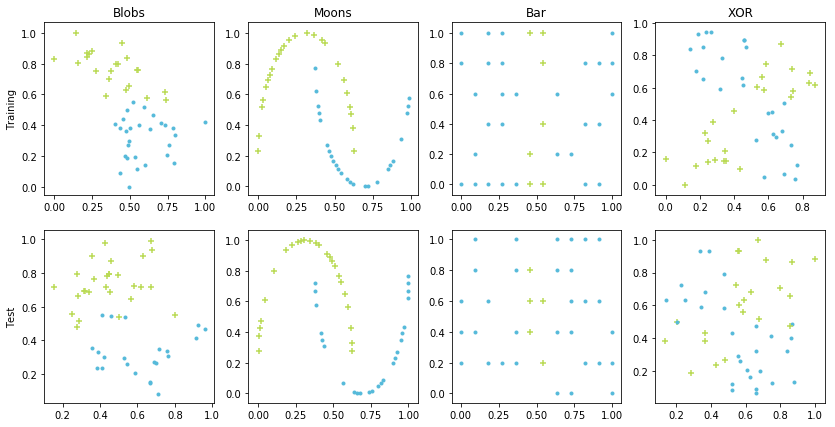

In [5]:
datasets = [
    ("Blobs", blobs_train, blobs_test),
    ("Moons", moons_train, moons_test),
    ("Bar", squares_train, squares_test),
    ("XOR", xor_train, xor_test)
]

visualize_datasets(datasets)

# Optimizing using PyTorch

Write an optimizer in PyTorch by taking using its default SGD class

In [25]:
def optimize(train_data, test_data, model, loss_fn = torch.nn.CrossEntropyLoss(), lr = 0.1, momentum = None):
    """
    Stochastic Gradient Descent optimizer
    
    :param train_data: torch.utils.data.dataset.Subset
    :param test_data: torch.utils.data.dataset.Subset
    :param model: torch.nn.Module (see https://pytorch.org/docs/stable/nn.html)
    :param loss_fn: torch.nn.modules.loss (see https://pytorch.org/docs/stable/nn.html#id51)
    :param lr: float, learning rate
    
    :return:
    - objectives, a list of loss values on the test dataset, collected at the end of each pass over the dataset (epoch)
    """
    # defatult pytorch functions which are useful for loading testing and training data
    train_loader = data.DataLoader(train_data, batch_size=10, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=NUM_SAMPLES)
    losses = []
        
    # ***************************************************
    # TODO: Define SGD optimizer with learning rate = lr
    # HINT: Use torch.optim.SGD and model.parameters()
    # ***************************************************
    if momentum is None:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    # Run SGD
    for epoch in range(1000):
        for minibatch, label in train_loader:
            
            optimizer.zero_grad() # Sets the previously computed gradients to zero to prevent accumulation
            
            # ***************************************************
            # TODO: prediction on minibatch
            # HINT: Use model.forward
            # ***************************************************
            prediction = model.forward(minibatch)
            
            # ***************************************************
            # TODO: compute the loss on prediction
            # HINT: Use loss_fn
            # ***************************************************
            loss = loss_fn(prediction, label.long())
            
            # ***************************************************
            # TODO: compute the minibatch gradient
            # HINT: Use loss.backward!
            # ***************************************************
            loss.backward()
            
            # ***************************************************
            # TODO: perform an SGD step
            # HINT: Use optimizer.step!
            # ***************************************************
            optimizer.step()
            
        # Compute the test loss
        # we let torch know that we dont intend to call .backward
        with torch.no_grad():
            test_data, test_labels = next(iter(test_loader))  # load the one and only test batch
            
            # ***************************************************
            # INSERT YOUR CODE HERE
            # TODO: compute the test prediction and test loss
            # ***************************************************
            prediction = model.forward(test_data)
            loss = loss_fn(prediction, test_labels.long())
            losses.append(loss.item())

            # Print the test loss to monitor progress
            if epoch % 100 == 0:
                print(epoch, loss.item())
                
    return losses

# Neural Networks

We will create a simple 2 layer neural network using the default functions provided by PyTorch

In [9]:
class NeuralNetwork(torch.nn.Sequential):
    def __init__(self, hidden_layer_size):
        self.name = 'NN'
        self.num_classes = 2
        # ***************************************************
        # TODO: Define your neural network model with ReLU
        # HINT: Use torch.nn.Sequential and torch.nn.ReLU
        # ***************************************************
        super().__init__(
            torch.nn.Linear(self.num_classes, hidden_layer_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer_size, self.num_classes)
        )
        
    def init_params(self, train_data):
        ''' No need to do anything since it is taken care of by torch.nn.Sequential'''
    
        

Plot the results while varying the size of the hidden layer in [20, 200, 1000]

What do you observe?

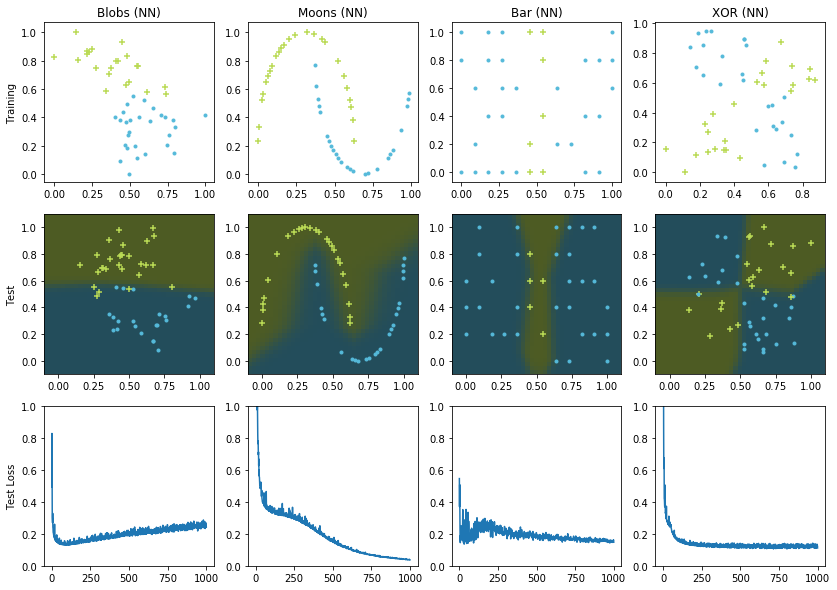

In [20]:
nn_model = NeuralNetwork(200)
visualize_predictions(datasets, nn_model, optimize)

Also try increase the number of layers. How does this effect the classifier learnt?

[This](https://playground.tensorflow.org/) is a cool website where you can play around more with training of neural networks on toy datasets.

## **Momentum** in training neural networks

In the lecture, we have seen how Nesterov momentum can accelerate gradient descent on convex functions. Let's now explore if similar benefits can be achieved on non-convex functions (neural networks in this case) and for *stochastic* gradient descent. It is important to note that theory usually describes convergence on the training objective. In a typical machine learning setting, however, we care about loss on _unseen_ data. For that reason, here, we will always look at loss on the test set.

__Exercise__<br> Add an argument `momentum` to your function `optimize` completed before. Hint: `torch.optim.SGD` also has a `momentum` argument that you can use. This implements heavy ball momentum, which is similar to, but [slightly different](https://dominikschmidt.xyz/nesterov-momentum/) from Nesterov momentum. You can try either variant, but they should have a similar effect.

### Hyper-parameter tuning

You will be comparing the SGD optimizers without momentum and with momentum of 0.9 (a common value). To do this fairly, you need to find good learning rates for either variant.

__Exercise__<br>
Find a good learning rate for SGD without momentum. You can try different learning rates on an exponential grid (i.e. 0.2, 0.4, 0.8, ...), and record the best test loss in each experiment with `np.min(losses)`. Use `NeuralNetwork(200)` as a model, and use this data:

In [14]:
dataset = datasets[1]  # and use this dataset, you can try others as well
dataset_name = dataset[0]
train_data = dataset[1]
test_data = dataset[2]
dataset_name

'Moons'

Tune lr **without** momentum:

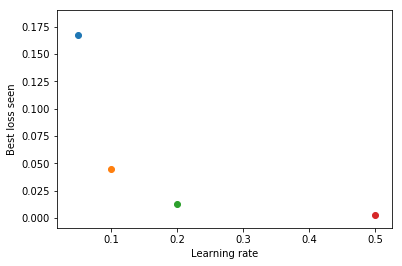

In [21]:
plt.xlabel("Learning rate")
plt.ylabel("Best loss seen")

best_loss = None
best_learning_rate = None

grid = [0.05, 0.1, 0.2, 0.5]
print("Learning rates to try:", grid)

for learning_rate in grid:
    model = NeuralNetwork(200)
    test_losses = optimize(train_data, test_data, model, lr=learning_rate)
    best_loss_achieved = np.min(test_losses)
    plt.scatter(learning_rate, best_loss_achieved)
    if best_loss is None or best_loss > best_loss_achieved:
        best_loss = best_loss_achieved
        best_learning_rate = learning_rate

In [22]:
f"The learning rate {best_learning_rate} worked well for SGD without momentum."

'The learning rate 0.5 worked well for SGD without momentum.'

Tune lr **with** momentum:

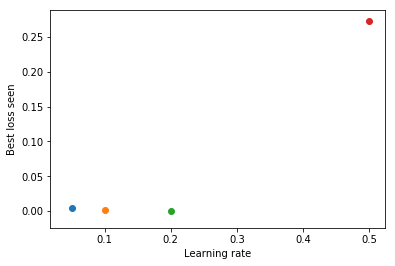

In [26]:
plt.xlabel("Learning rate")
plt.ylabel("Best loss seen")

best_loss = None
best_learning_rate = None

# The grid is chosen by trial and error in this case, 
grid = [0.05, 0.1, 0.2, 0.5]
print("Learning rates to try:", grid)

for learning_rate in grid:
    model = NeuralNetwork(200)
    test_losses = optimize(train_data, test_data, model, lr=learning_rate, momentum=0.9)
    best_loss_achieved = np.min(test_losses)
    plt.scatter(learning_rate, best_loss_achieved)
    if best_loss is None or best_loss > best_loss_achieved:
        best_loss = best_loss_achieved
        best_learning_rate = learning_rate

In [27]:
f"The learning rate {best_learning_rate} worked well for SGD with 0.9 momentum."

'The learning rate 0.2 worked well for SGD with 0.9 momentum.'

### Comparing the optimizers

__Exercise__<br>
Plot test loss curves for both optimizers with the best learning rates you found for each. Do you see a benefit of momentum? How stable are the improvements over different datasets or different initializations? Can you think of ways to make the hyperparameter search procedure more stable?

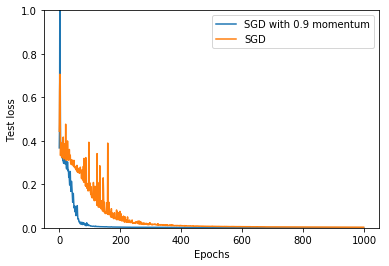

In [30]:
model = NeuralNetwork(200)  # reinitialize the model
plt.plot(optimize(train_data, test_data, model, lr=0.2, momentum=0.9), label="SGD with 0.9 momentum")

model = NeuralNetwork(200)  # reinitialize the model
plt.plot(optimize(train_data, test_data, model, lr=0.5, momentum=None), label="SGD")

plt.ylabel("Test loss")
plt.xlabel("Epochs")
plt.ylim([0, 1])
plt.legend();

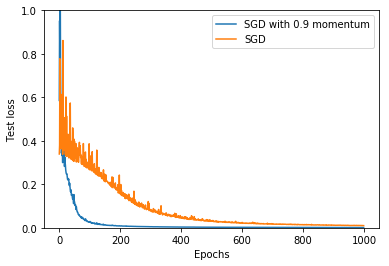

In [31]:
# defining a different model and using the second best lrs

model = NeuralNetwork(420)  # reinitialize the model
plt.plot(optimize(train_data, test_data, model, lr=0.1, momentum=0.9), label="SGD with 0.9 momentum")

model = NeuralNetwork(420)  # reinitialize the model
plt.plot(optimize(train_data, test_data, model, lr=0.2, momentum=None), label="SGD")

plt.ylabel("Test loss")
plt.xlabel("Epochs")
plt.ylim([0, 1])
plt.legend();

Do you see a benefit of momentum? 
- SGB with momentum converged a lot faster than the regular SGD, and without much noise. 
How stable are the improvements over different datasets or different initializations?
- Over different initializations of the model and/or using different learning rates, we still observe that the SGD is quite stable.
Can you think of ways to make the hyperparameter search procedure more stable?
- One way would be to add cross validation when tuning the parameters.